In [33]:
import os
from typing import List, Optional

import numpy as np
import wfdb
from wfdb import processing
from tqdm import tqdm
import warnings


import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, filtfilt
from scipy import signal

import neurokit2 as nk

warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

DB_ALIASES = {
    "AFDB": "../mit-bih-atrial-fibrillation-database-1.0.0/files",
    "LTAFDB": "../long-term-af-database-1.0.0/files",
    "NSRDB": "../mit-bih-normal-sinus-rhythm-database-1.0.0/files",
}

directory = "./tq_segments"


def clean_annotation(annotation):
    sample, aux_note = annotation.sample, annotation.aux_note
    non_empty_indices = [i for i, note in enumerate(aux_note) if note != ""]
    clean_aux_note = [aux_note[i] for i in non_empty_indices]
    clean_sample = [sample[i] for i in non_empty_indices]
    return clean_sample, clean_aux_note


def get_ranges_afib(record_path: str, signal_len: int) -> List[List[int]]:
    annotation = wfdb.rdann(record_path, "atr")
    sample, aux_note = clean_annotation(annotation)
    ranges_interest = []
    for i, label in enumerate(aux_note):
        if label == "(AFIB":
            afib_start = sample[i]
            last_notation = len(sample) == (i + 1)
            afib_end = signal_len if last_notation else sample[i + 1] - 1
            ranges_interest.append([afib_start, afib_end])
    return ranges_interest


def cut_array(array_rri: List[int], segment_len: int) -> np.ndarray:
    num_segments = len(array_rri) // segment_len

    if num_segments <= 0:
        return np.empty((0, 0))

    segments = np.array(
        [
            array_rri[i : i + segment_len]
            for i in range(0, num_segments * segment_len, segment_len)
        ]
    )
    return segments


def get_random_samples_by_label(
    base: np.ndarray,
    label: int,
    n_samples: Optional[int] = 0,
) -> np.ndarray:
    samples = base[base[:, -1] == label]

    if n_samples:
        indexes = np.random.choice(samples.shape[0], n_samples, replace=False)
        return samples[indexes]

    return samples


def get_random_samples(base: np.ndarray, qtd_segments: int) -> np.ndarray:
    qtd_segments = int(qtd_segments / 2)
    negatives = get_random_samples_by_label(base=base, label=0, n_samples=qtd_segments)
    positives = get_random_samples_by_label(base=base, label=1, n_samples=qtd_segments)
    base_ready = np.vstack((positives, negatives))
    return base_ready


def get_record_ids(db_alias: str) -> List[str]:
    with open(f"{DB_ALIASES[db_alias]}/RECORDS") as f:
        lines = f.readlines()
        record_ids = [line.strip() for line in lines]

    if db_alias == "AFDB":
        record_ids.remove("00735")
        record_ids.remove("03665")

    return record_ids


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype="band")
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y


def filter_signal(ecg1):
    lowcut = 0.05
    highcut = 40.0
    fs = 250
    order = 4

    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    # Design the Butterworth filter
    b, a = signal.butter(order, [low, high], btype="band")

    # Apply the filter to your signal
    filtered_signal = signal.lfilter(b, a, ecg1)

    return filtered_signal


def extract_segments_bins() -> np.ndarray:
    if not os.path.exists(directory):
        os.makedirs(directory)

    filename = f"tq_segments.npy"

    path = os.path.join(directory, filename)

    if os.path.isfile(path):
        segment_bins = np.load(path)
        return get_random_samples(segment_bins)

    # base = np.empty((0, m_bins + 1))

    for db_alias in DB_ALIASES.keys():
        # label = 0 if db_alias == "NSRDB" else 1
        extension_signal = "atr" if db_alias == "NSRDB" else "qrs"

        record_ids = get_record_ids(db_alias)

        for record_id in tqdm(record_ids):
            record_path = os.path.join(DB_ALIASES[db_alias], record_id)

            _, ecg_metadata = wfdb.rdsamp(record_path)
            signal_len = ecg_metadata["sig_len"]

            extract_intervals = (
                get_ranges_afib(record_path, signal_len)
                if db_alias in ["AFDB", "LTAFDB"]
                else [[0, signal_len - 1]]
            )

            rec = wfdb.rdrecord(record_name=record_path)

            for start_index, end_index in extract_intervals:
                signal_recording = rec.p_signal[:, 0][start_index:end_index]
                # ecg1 = filter_signal(signal_recording)
                ann = wfdb.rdann(
                    record_path,
                    sampfrom=start_index,
                    sampto=end_index,
                    extension=extension_signal,
                )

                r_peaks = [i - start_index for i in ann.sample]

                _, peak_waves = nk.ecg_delineate(
                    ecg_cleaned=signal_recording,
                    rpeaks=r_peaks,
                    sampling_rate=250,
                    method="peak",
                    show=True,
                )

                ecg_t_peaks = peak_waves["ECG_T_Peaks"]
                ecg_q_peaks = peak_waves["ECG_Q_Peaks"]

                tq_segments = []

                initial_t_peaks = ecg_t_peaks[0]
                initial_q_peaks = ecg_q_peaks[0]

                if initial_t_peaks > initial_q_peaks:
                    ecg_q_peaks = ecg_q_peaks[1:]

                for t_peak, q_peak in zip(ecg_t_peaks, ecg_q_peaks):
                    print(t_peak, q_peak)
                    if t_peak < q_peak:
                        tq_segment = signal_recording[t_peak : q_peak + 1]
                        tq_segments.append(tq_segment)
                    else:
                        print("Invalid T-peak or Q-peak:", t_peak, q_peak)

                return tq_segments

                break

            break
        break
    return

    num_rows = base.shape[0]
    permutation = np.random.permutation(num_rows)
    shuffled_base = base[permutation].copy()

    np.save(path, shuffled_base)

    return get_random_samples(shuffled_base, qtd_segments)

  0%|          | 0/23 [00:02<?, ?it/s]

132 176
234 318
400 388
Invalid T-peak or Q-peak: 400 388
503 519
606 625
717 745
813 901
969 998
1043 1087
1123 1181
nan 1246
Invalid T-peak or Q-peak: nan 1246
1294 1338
1435 1452
nan 1516
Invalid T-peak or Q-peak: nan 1516
nan nan
Invalid T-peak or Q-peak: nan nan
1693 1676
Invalid T-peak or Q-peak: 1693 1676
nan 1805
Invalid T-peak or Q-peak: nan 1805
1870 1885
1966 nan
Invalid T-peak or Q-peak: 1966 nan
2058 2095
2159 nan
Invalid T-peak or Q-peak: 2159 nan
2295 2345
nan 2466
Invalid T-peak or Q-peak: nan 2466
2546 2622
2687 2741
2823 2847
2905 2959
3047 3071
3137 3172
3235 3261
3366 3378
3474 3451
Invalid T-peak or Q-peak: 3474 3451
3542 3622
3710 3737
nan 3823
Invalid T-peak or Q-peak: nan 3823
3922 3947
4036 4092
4128 4151
4225 4319
4391 4415
4504 4506
4550 4632
4722 4753
4819 4882
4950 5008
nan 5074
Invalid T-peak or Q-peak: nan 5074
5185 5212
5291 5311
5389 5387
Invalid T-peak or Q-peak: 5389 5387
5445 5552
5596 5663
5711 5783
5849 5924
nan 6041
Invalid T-peak or Q-peak: nan 6

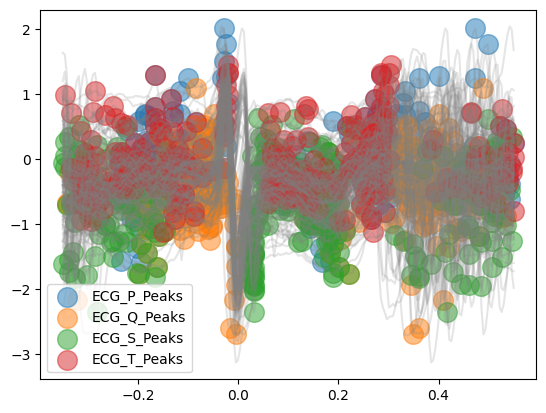

In [34]:
base = extract_segments_bins()

In [35]:
[i.shape for i in base]

[(45,),
 (85,),
 (17,),
 (20,),
 (29,),
 (89,),
 (30,),
 (45,),
 (59,),
 (45,),
 (18,),
 (16,),
 (38,),
 (51,),
 (77,),
 (55,),
 (25,),
 (55,),
 (25,),
 (36,),
 (27,),
 (13,),
 (81,),
 (28,),
 (26,),
 (57,),
 (24,),
 (95,),
 (25,),
 (3,),
 (83,),
 (32,),
 (64,),
 (59,),
 (28,),
 (21,),
 (108,),
 (68,),
 (73,),
 (76,),
 (13,),
 (100,),
 (18,),
 (81,),
 (10,),
 (75,),
 (81,),
 (70,),
 (44,),
 (57,),
 (65,),
 (31,),
 (49,),
 (29,),
 (82,),
 (97,),
 (81,),
 (22,),
 (60,),
 (86,),
 (77,),
 (28,),
 (29,),
 (21,),
 (22,),
 (20,),
 (16,),
 (29,),
 (23,),
 (13,),
 (22,),
 (12,),
 (62,),
 (39,),
 (50,),
 (55,),
 (19,),
 (50,),
 (42,),
 (58,),
 (27,),
 (34,),
 (75,),
 (127,),
 (138,),
 (74,),
 (40,),
 (6,),
 (28,),
 (66,),
 (33,),
 (75,),
 (31,),
 (61,),
 (98,),
 (54,),
 (17,),
 (62,),
 (39,),
 (94,),
 (79,),
 (32,),
 (32,),
 (15,),
 (11,),
 (44,),
 (18,),
 (58,),
 (29,),
 (32,),
 (79,),
 (18,),
 (42,),
 (73,),
 (20,),
 (38,),
 (20,),
 (28,)]

In [13]:
len(base)

134

IndexError: list index out of range

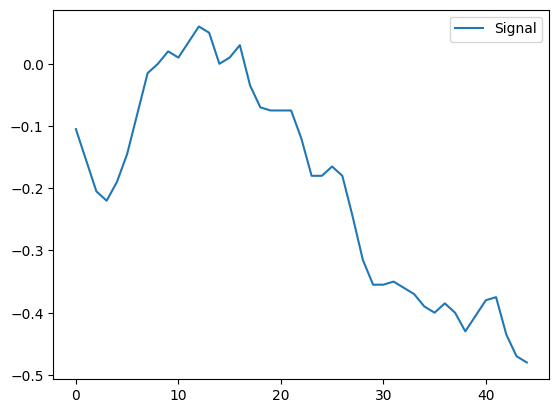

In [37]:
plot = nk.events_plot([], base[0])
